# Imports & Settings

In [117]:
import warnings

import pandas as pd  
import numpy as np
from numpy.random import random, uniform, normal, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use('fivethirtyeight')
np.random.seed(42)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

In [4]:
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

# Prepare Data

In [5]:
with pd.HDFStore('../../00_data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks'].index 
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)

## Compute Returns

In [6]:
start = 1988
end = 2017

In [7]:
monthly_returns = prices.loc[f'{start}':f'{end}'].resample('M').last().pct_change().dropna(how='all')
monthly_returns = monthly_returns.dropna(axis=1)
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Columns: 217 entries, MMM to XRX
dtypes: float64(217)
memory usage: 611.4 KB


## Set  Parameters

In [8]:
stocks = monthly_returns.columns

In [9]:
n_obs, n_assets = monthly_returns.shape
n_assets, n_obs

(217, 359)

In [324]:
NUM_PF = 500000 # no of portfolios to simulate

In [49]:
x0 = uniform(-1, 1, n_assets)
x0 /= np.sum(np.abs(x0))

### Annualization Factor

In [12]:
periods_per_year = round(monthly_returns.resample('A').size().mean())
periods_per_year

12

## Compute Covariance

In [13]:
mean_returns = monthly_returns.mean()
cov_matrix = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

In [14]:
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())

## Risk-Free Rate

In [15]:
rf_rate = treasury_10yr_monthly.mean()

## Simulate Random Portfolios

In [325]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.01)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ monthly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std

    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

In [326]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix)

### Plot Simulated Portfolios

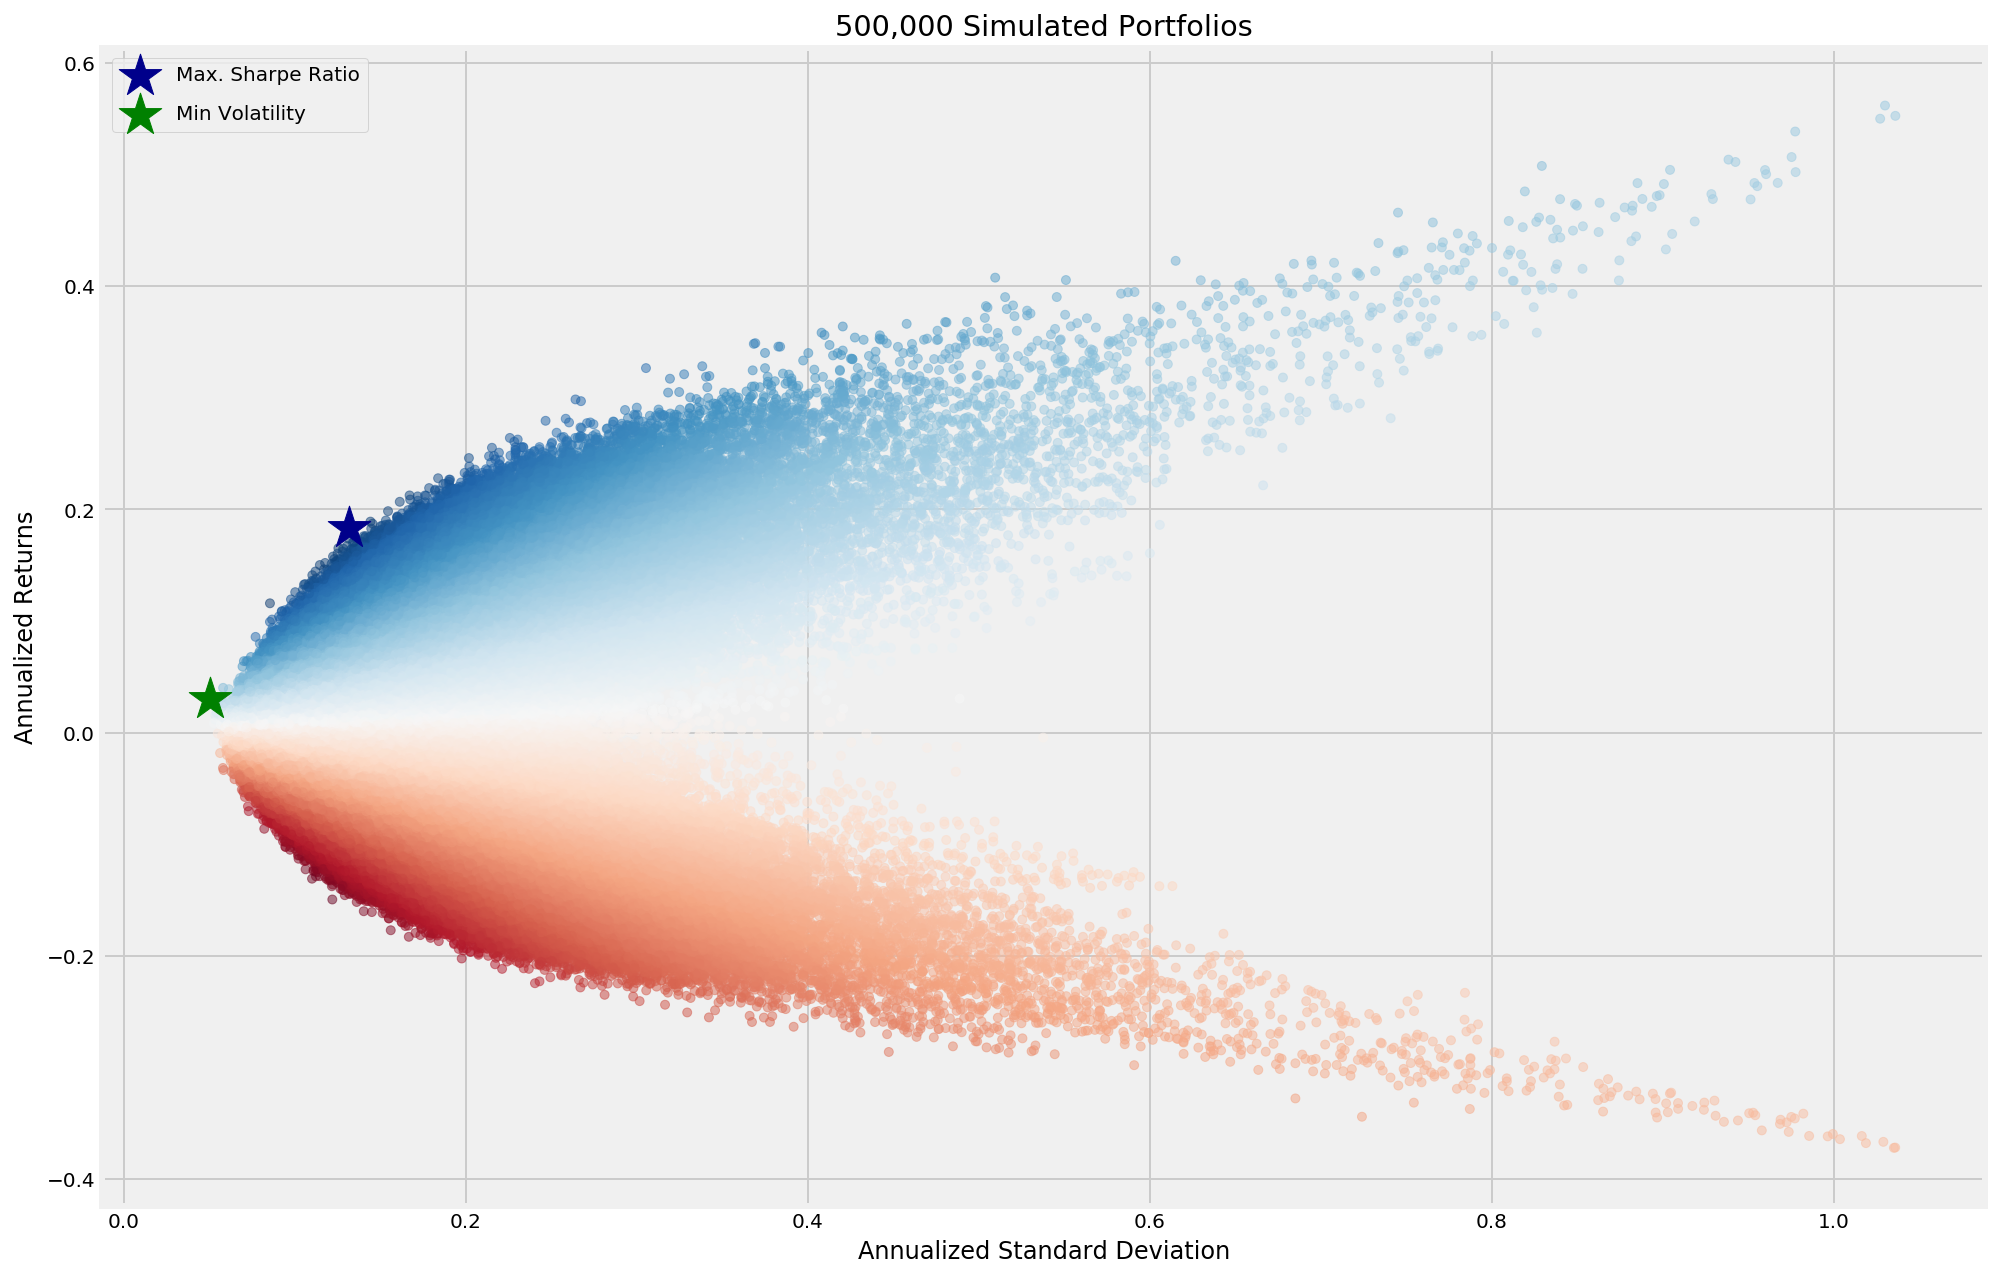

In [327]:
# pandas 0.24 will fix bug with colorbars: https://github.com/pandas-dev/pandas/pull/20446
ax = simul_perf.plot.scatter(x=0, y=1, c=2,
                             cmap='RdBu',
                             alpha=0.5, figsize=(14, 9), colorbar=False,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
ax.scatter(sd, r, marker='*', color='darkblue',
           s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

## Compute Annualize PF Performance

In [328]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [329]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [330]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

In [331]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

## Max Sharpe PF

In [332]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x)) - 1}

In [333]:
def max_sharpe_ratio(mean_ret, cov, short=True):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

## Min Volatility Portfolio

In [334]:
def min_vol(mean_ret, cov, short=True):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

## Compute Efficient Frontier

In [335]:
def min_vol_target(mean_ret, cov, target, short=True):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq', 'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [336]:
def efficient_frontier(mean_ret, cov, ret_range):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

## Run Calculation

### Get random PF

In [295]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=True)

In [337]:
print(simul_perf.describe())

       Annualized Standard Deviation  Annualized Returns  Sharpe Ratio
count                     500000.000          500000.000    500000.000
mean                           0.169               0.004        -0.007
std                            0.065               0.097         0.529
min                            0.050              -0.372        -1.261
25%                            0.126              -0.075        -0.489
50%                            0.155              -0.000        -0.035
75%                            0.195               0.080         0.474
max                            1.036               0.562         1.356


In [338]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation   0.132
Annualized Returns              0.183
Sharpe Ratio                    1.356
Name: 297671, dtype: float64

### Get Max Sharpe PF

In [339]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [340]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret   0.037
sd    0.009
sr    3.515
dtype: float64

From simulated pf data

### Get Min Vol PF

In [341]:
min_vol_pf = min_vol(mean_returns, cov_matrix)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

### Get Efficent PFs

In [342]:
ret_range = np.linspace(0, simul_perf.iloc[:, 1].max() * 1.1, 25)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range)

In [343]:
[pf.x.max() for pf in eff_pf]

[0.019251641879355904,
 0.019902684512464554,
 0.027306200613979356,
 0.04208177297377508,
 0.053082620191190706,
 0.06674212648616029,
 0.09155019122382105,
 0.1139851901625401,
 0.12490361871309066,
 0.11778893145572475,
 0.10760850644566516,
 0.12874242079558948,
 0.12208927904455699,
 0.11280263570984965,
 0.14751412537817415,
 0.1985057794569503,
 0.26561995428671675,
 0.3411860266655225,
 0.37967639656617364,
 0.44855180128964584,
 0.582921656198899,
 0.718214875177695,
 0.8705147864151869,
 0.9999998578420596,
 1.0]

### Plot Result

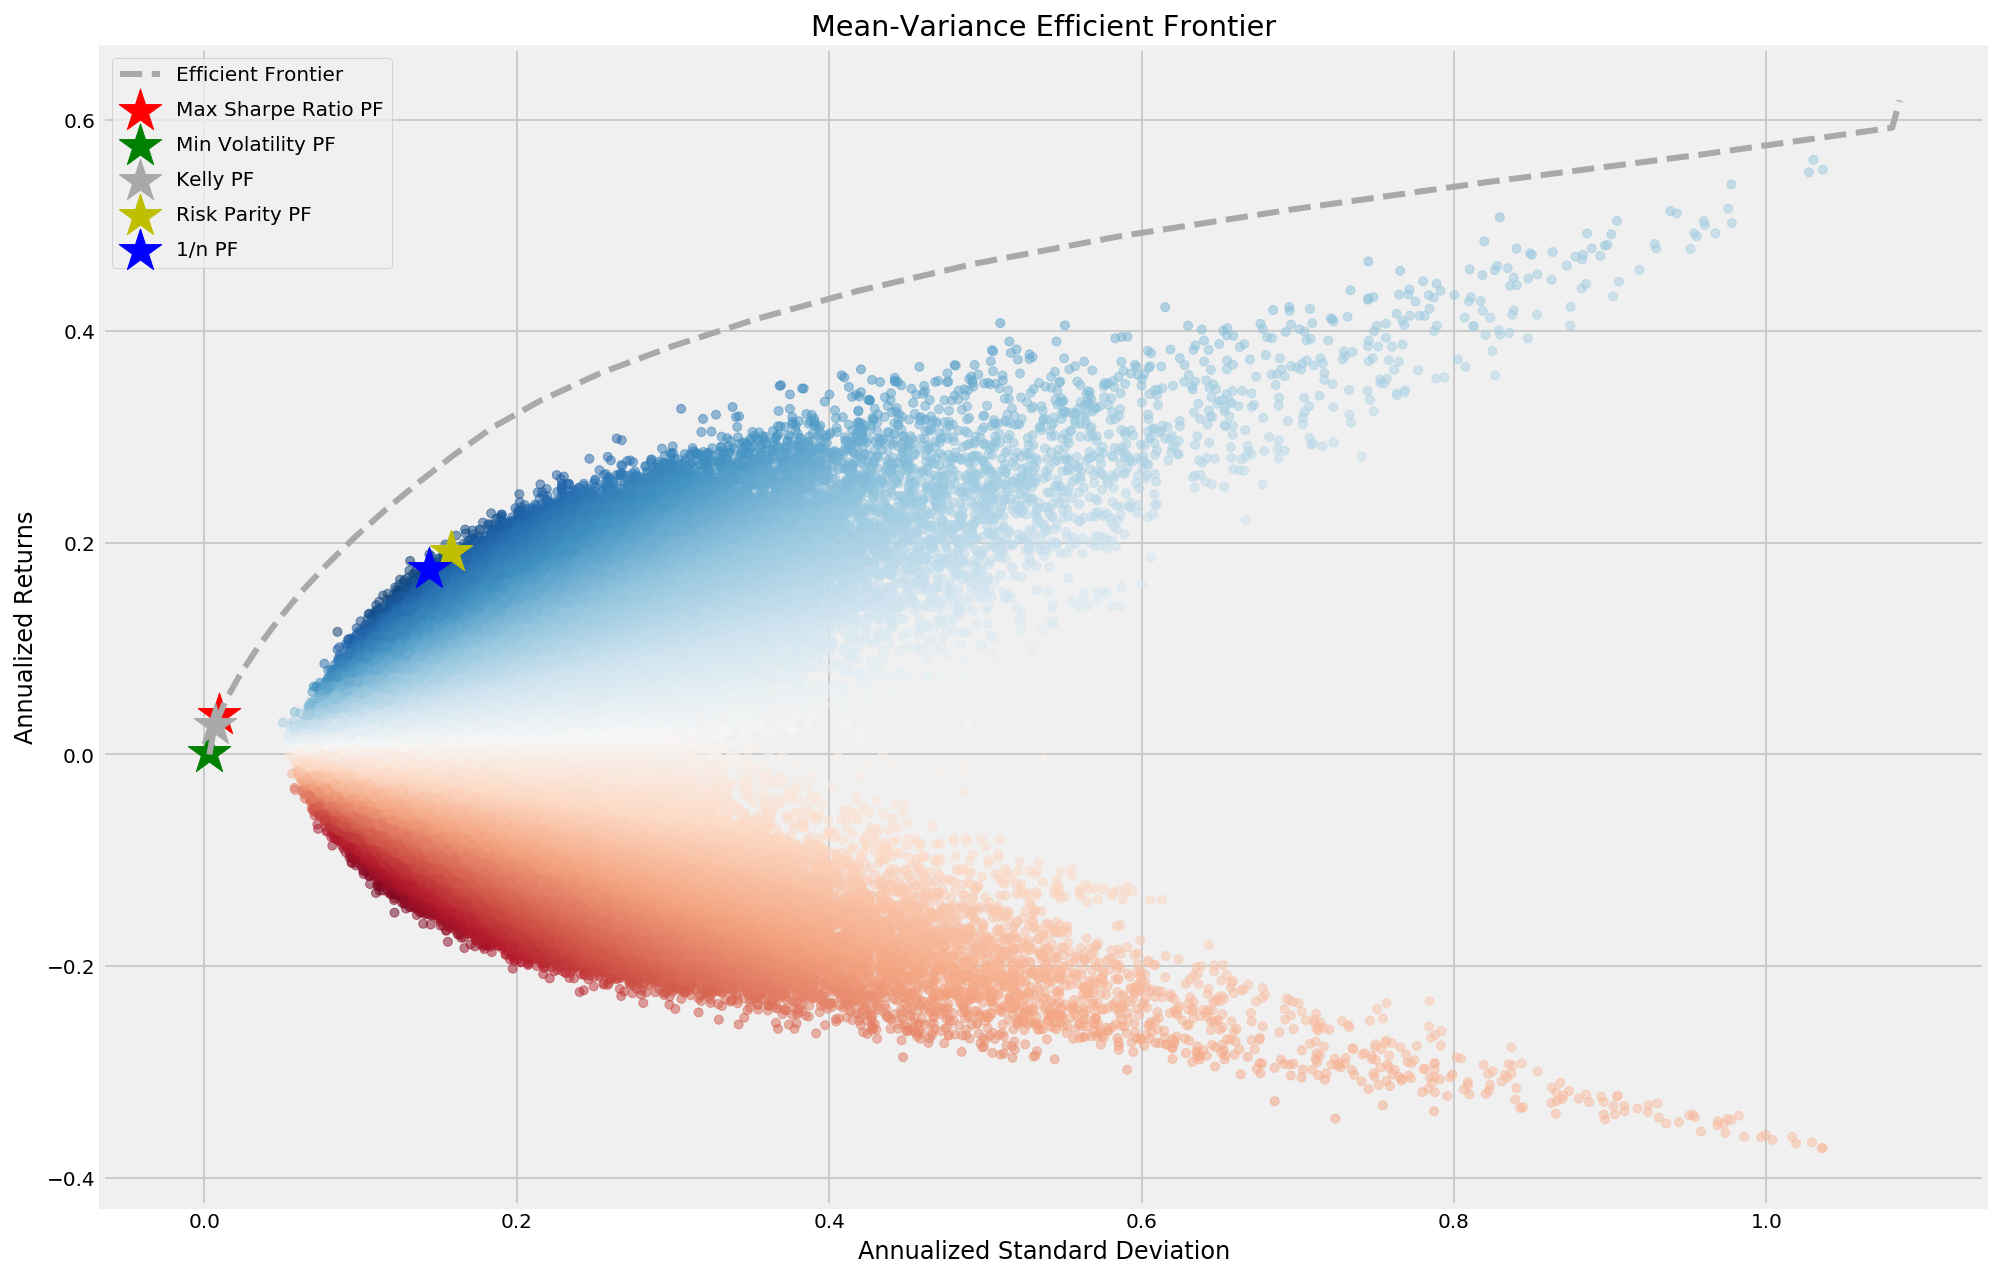

In [344]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax,
                                 cmap='RdBu',
                                 alpha=0.5, figsize=(14, 9), colorbar=False,
                                 title='Mean-Variance Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='r', s=500, label='Max Sharpe Ratio PF')
r, sd = min_vol_perf
ax.scatter(sd, r, marker='*', color='g', s=500, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='*', color='darkgrey', s=500, label='Kelly PF')

std = monthly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='*', color='y', s=500, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='*', color='blue', s=500, label='1/n PF')

ax.plot([p['fun'] for p in eff_pf], ret_range, 
        linestyle='--', lw=3, color='darkgrey', label='Efficient Frontier')
ax.legend(labelspacing=0.8)
fig.tight_layout();

In [311]:
std = monthly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
r, sd

(0.19091903997200999, 0.15813414921037125)

In [ ]:
# sd, r, _ = simul_perf.iloc[simul_max_sharpe].values
# ax.scatter(sd, r, marker='*', color='g', s=500, label='Simul PF')
